# SkimLit
SkimLit is a project that aims to build an NLP model to make PubMed RCT abstract easier to read by classifying sentences in the abstract into the right section.

This project is based on the paper "PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts" available at https://arxiv.org/abs/1710.06071

Dataset: PubMed 200K RCT Dataset\
Available at: https://github.com/Franck-Dernoncourt/pubmed-rct

by : Rasyadan Faza

## Get and Check Dataset

In [1]:
# Get the dataset from the github repository
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 21.30 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


**This project only uses the 20k dataset although it can be scaled to use the full 200k dataset**

In [2]:
# Check files in PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
# Set the data to use
data_dir_20k = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [4]:
# Check the filenames in the target directory
import os
filenames = [data_dir_20k + filename for filename in os.listdir(data_dir_20k)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt']

## Data Exploration & Preparation

In [5]:
# Function to read all the lines in a text file
def get_file_lines(filename):
  """
  Reads a text filename and returns the lines of the text as a list.

  Args:
      filename: a string containing path to target file

  Returns:
      A list of string with one string per line from the target file
  """

  with open(filename, 'r') as file:
    return file.readlines()

In [6]:
# Read the training.txt lines
train_lines = get_file_lines(data_dir_20k + "/train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

**HIghlight**

* Each abstract is separated by ### followed by its id
* Each sentence has its label at the start of the sentence separated by a tab (\t)
* Each abstract ended with a newline (\n)
* Every number is replace by an `@` sign

In [7]:
# Length of train lines
len(train_lines)

210040

For every line in the train lines, create a list of dictionary for each sentence that contains:
```
{
  'line_num': the line number the sentence is at,
  'target': target label of the sentence in the line,
  'text': content of the sentence,
  'total_lines': total number of lines in each abstract
}
```

In [8]:
# Create data preprocessing function
def preprocess_data(filename):
  input_lines = get_file_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  # Loop through each line in target file
  for line in input_lines:
    if (line.startswith("###")): # start of an abstract
      abstract_id = line
      abstract_lines = ""
    elif(line.isspace()): #if line is the end of the abstract
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract
      for abstract_line_num, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["line_num"] = abstract_line_num
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["total_lines"] = len(abstract_line_split) - 1 # total lines in the target abstract (start from 0)
        abstract_samples.append(line_data)
    else:
      abstract_lines += line

  return abstract_samples

In [9]:
%%time
# Get data from file and preprocess it
train_samples = preprocess_data(data_dir_20k + "/train.txt")
val_samples = preprocess_data(data_dir_20k + "/dev.txt")
test_samples = preprocess_data(data_dir_20k + "/test.txt")

CPU times: user 751 ms, sys: 111 ms, total: 863 ms
Wall time: 1.14 s


In [10]:
len(train_samples), len(val_samples), len(train_samples)

(180040, 30212, 180040)

In [11]:
# Check samples of training data
train_samples[:15]

[{'line_num': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_num': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_num': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_num': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_num': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures included the western o

In [12]:
# Format data into Pandas DataFrame
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(15)

,line_num,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

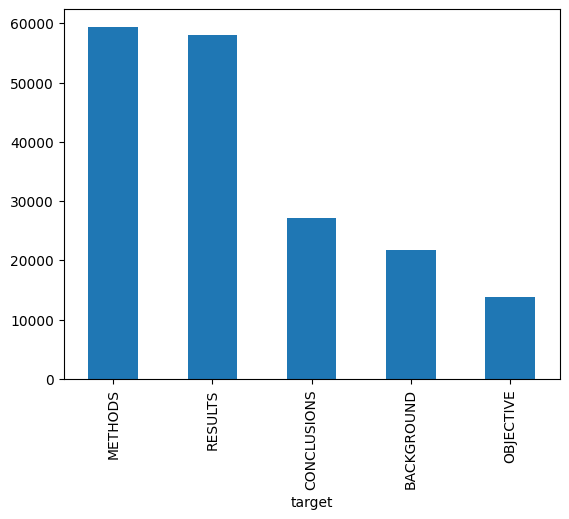

In [13]:
# Check distribution of each labels
train_df.target.value_counts().plot(kind="bar");
train_df.target.value_counts()

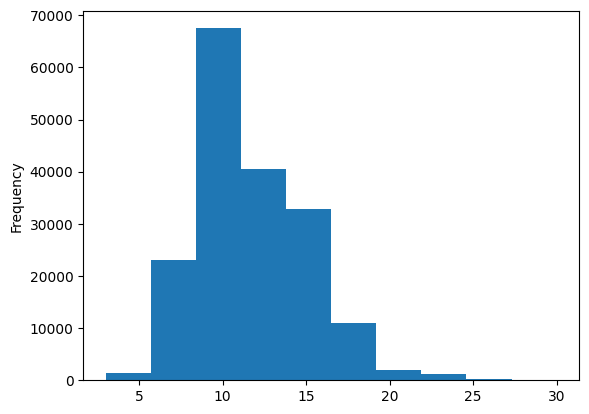

In [14]:
# Length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences

In [15]:
# Convert text lines into list
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# First 10 lines of train sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Converting text data into numerical form

In [17]:
# Convert labels into numerical form
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
train_labels_one_hot = ohe.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = ohe.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = ohe.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check the training labels
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode target labels

In [18]:
# Convert labels into numerical form
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = le.transform(val_df["target"].to_numpy())
test_labels_encoded = le.transform(test_df["target"].to_numpy())

# Check the training labels
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Check mapping of labels
dict(zip(le.classes_, le.transform(le.classes_)))

{'BACKGROUND': 0, 'CONCLUSIONS': 1, 'METHODS': 2, 'OBJECTIVE': 3, 'RESULTS': 4}

## Modelling Experimentation

Starting a series of modelling experiments with various models to see which one works best

In [20]:
# Evaluation function
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def evaluate_results(y_true, y_pred):
  """
  Output evaluation metrics (accuracy, precision, recall, and f1 score) of a binary classification model
  """

  # Calculate model accuracy
  model_acc = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall, and f1-score with weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

  return {
      "accuracy": model_acc,
      "precision": model_precision,
      "recall": model_recall,
      "f1": model_f1
  }

def get_model_res(model):
  val_preds = model.predict(val_sentences)
  return evaluate_results(val_labels_encoded, val_preds)

### Model 0 (Baseline): TF-IDF Multinomial Naive Bayes Classifier

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [22]:
# Create a pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to training data
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evaluate baseline model on validation dataset
model_0_res = get_model_res(model_0)
model_0_res

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing data for deep sequence models

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [25]:
# Check average of each sentence length
sentence_length = [len(sentence.split()) for sentence in train_sentences]
np.mean(sentence_length)

26.338269273494777

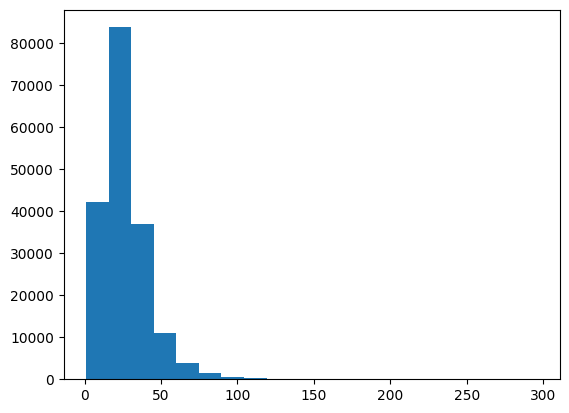

In [26]:
# Check the distribution of sentence lengths
import matplotlib.pyplot as plt
plt.hist(sentence_length, bins=20);

In [27]:
# Find out sentence length that covers 95% examples
output_seq_len = int(np.percentile(sentence_length, 95))

In [28]:
# Max length of sentences in training data
np.max(sentence_length)

296

#### Create TextVectorization layer for tokenization

In [29]:
# How many words in vocabulary (based on table 2 in the paper)
max_words = 68000

In [30]:
# Text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_words, output_sequence_length=output_seq_len, pad_to_max_tokens=True)

# Fit to data
text_vectorizer.adapt(train_sentences)

In [31]:
# Test text vectorizer on random sentence
import random
random_sentence = random.choice(train_sentences)
print(f"Text: \n{random_sentence}\n")
print(f"Length of text: {len(random_sentence.split())}\n")
print(f"Vectorized text:\n{text_vectorizer(random_sentence)}")

Text: 
part @ compared the closure of surgical incisions with n-butyl-@ cyanoacrylate and subcuticular suture .

Length of text: 15

Vectorized text:
[  732    34     2  1226     4   306  4891     7 15720  7245     3  5872
  1875     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [32]:
# Count of words in training voacbulary
text_vocab_20k = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(text_vocab_20k)}")
print(f"Most common words in the vocab: {text_vocab_20k[:5]}")
print(f"Least common words in the vocab: {text_vocab_20k[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


#### Create Text Embedding Layer

In [33]:
from tensorflow.keras import layers
token_embedding = layers.Embedding(input_dim=len(text_vocab_20k), output_dim=128,
                                   mask_zero=True, name="token_embedding", )

In [34]:
# Embedding example
print(f"Sentence before vectorization: \n{random_sentence}")
print(f"Sentence after vectorization: \n{text_vectorizer([random_sentence])}")
print(f"Sentence after embedding: \n{token_embedding(text_vectorizer([random_sentence]))}")
print(f"Embedded sentence shape: \n{token_embedding(text_vectorizer([random_sentence])).shape}")

Sentence before vectorization: 
part @ compared the closure of surgical incisions with n-butyl-@ cyanoacrylate and subcuticular suture .
Sentence after vectorization: 
[[  732    34     2  1226     4   306  4891     7 15720  7245     3  5872
   1875     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding: 
[[[-0.03515408  0.02280912 -0.02702746 ... -0.03742807 -0.03386949
   -0.03892078]
  [ 0.01786217  0.01432068 -0.03371648 ...  0.02950913  0.03873383
    0.00935314]
  [-0.02405236 -0.02585658  0.02772189 ...  0.04030121  0.01022657
   -0.00189272]
  ...
  [ 0.02413804 -0.01264755  0.04144759 ... -0.00246008 -0.00798303
    0.00668204]
  [ 0.02413804 -0.01264755  0.04144759 ... -0.00246008 -0.00798303
    0.00668204]
  [ 0.02413804 -0.01264755  0.04144759 ...

#### Load dataset using TensorFlow Data API

In [35]:
# Turn data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [36]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [37]:
# Take TensorSliceDataset and turn it into prefetched dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: 1D Convolution Model with token embeddings

In [38]:
# Create 1D Conv. model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embedding(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_1d_conv")

In [39]:
model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [40]:
model_1.summary()

Model: "model_1_1d_conv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                   

In [41]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=5,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)),
                              verbose=True
                              )

Epoch 1/5
562/562 [==============================] - 21s 32ms/step - loss: 0.8368 - accuracy: 0.6874 - val_loss: 0.5871 - val_accuracy: 0.7759
Epoch 2/5
562/562 [==============================] - 6s 11ms/step - loss: 0.5794 - accuracy: 0.7852 - val_loss: 0.5405 - val_accuracy: 0.8022
Epoch 3/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5455 - accuracy: 0.7959 - val_loss: 0.5207 - val_accuracy: 0.8072
Epoch 4/5
562/562 [==============================] - 4s 8ms/step - loss: 0.5257 - accuracy: 0.8083 - val_loss: 0.5196 - val_accuracy: 0.8088
Epoch 5/5
562/562 [==============================] - 10s 18ms/step - loss: 0.5300 - accuracy: 0.8072 - val_loss: 0.5002 - val_accuracy: 0.8128


In [42]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

945/945 [==============================] - 5s 5ms/step


array([[4.7058004e-01, 3.8865593e-01, 3.8736218e-03, 1.2112697e-01,
        1.5763354e-02],
       [4.0571010e-01, 5.1799899e-01, 2.4903603e-03, 4.7036126e-02,
        2.6764371e-02],
       [3.5253882e-01, 7.1972646e-02, 1.3327753e-02, 5.5804312e-01,
        4.1176802e-03],
       ...,
       [4.9846142e-04, 6.2033790e-04, 1.0787630e-02, 1.7365358e-04,
        9.8791993e-01],
       [2.4683522e-02, 5.6132734e-01, 3.3346295e-02, 1.0598355e-02,
        3.7004450e-01],
       [4.9362432e-02, 9.3318802e-01, 7.0638498e-03, 3.0894394e-03,
        7.2963359e-03]], dtype=float32)

In [43]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [44]:
# Evaluate results
model_1_res = evaluate_results(val_labels_encoded, model_1_preds)
model_1_res

{'accuracy': 0.8178538329140739,
 'precision': 0.8201487401968537,
 'recall': 0.8178538329140739,
 'f1': 0.8152048527902559}

### Model 2: TensorFlow Hub Pretrained Feature Extractor

Using Tensorflow Universal Sentence Encoder v4

In [45]:
# Download pretrained TF Hub
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [46]:
# Test pretrained embedding
random_train_sentence = random.choice(train_sentences)
embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(random_train_sentence)
print(embedded_sentence[:30])

the cgs array developed in this study enabled typing of influenza b viruses in human clinical specimens .
tf.Tensor(
[[ 3.10080452e-03  4.33603004e-02 -5.86840250e-02 -4.04084362e-02
   2.12094057e-02  1.06498115e-02  5.22142127e-02  6.36107847e-02
  -2.85387933e-02  4.76216860e-02  8.45230296e-02 -7.53884837e-02
   7.72072151e-02  3.93932201e-02  1.99302714e-02 -5.52300215e-02
  -8.41462910e-02 -6.48299083e-02  6.46270066e-02 -7.79030472e-02
  -7.71620870e-02 -3.43752541e-02 -5.25092967e-02  7.73073807e-02
  -6.10342808e-02 -5.40723838e-02 -5.31250611e-02 -6.46535680e-02
   3.74995917e-02 -5.91261126e-02  1.96034573e-02  8.47897530e-02
  -7.30435876e-03 -2.95955092e-02 -4.17723209e-02 -2.72870082e-02
  -6.92676008e-02 -2.59094071e-02 -3.89048904e-02 -3.85883613e-03
   2.29426404e-03  4.30328436e-02 -6.90786839e-02  6.04800042e-03
   2.92471237e-02 -3.10754757e-02  6.82117976e-03  1.01765143e-02
   1.07062003e-02  3.53582832e-03 -1.52940070e-02 -7.73139065e-03
  -3.12935337e-02  1.6927

In [47]:
inputs = layers.Input(shape=[], dtype=tf.string)
x = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="tf_hub_pretrained_embedding")

In [48]:
model_2.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
model_2.summary()

Model: "tf_hub_pretrained_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [49]:
# Fit the model
model_2_history = model_2.fit(train_dataset, steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=5, validation_data=val_dataset, validation_steps=int(0.1*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 11s 15ms/step - loss: 0.9173 - accuracy: 0.6508 - val_loss: 0.7982 - val_accuracy: 0.6892
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7682 - accuracy: 0.7022 - val_loss: 0.7536 - val_accuracy: 0.7051
Epoch 3/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7501 - accuracy: 0.7122 - val_loss: 0.7373 - val_accuracy: 0.7134
Epoch 4/5
562/562 [==============================] - 9s 17ms/step - loss: 0.7172 - accuracy: 0.7256 - val_loss: 0.7090 - val_accuracy: 0.7301
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7242 - accuracy: 0.7224 - val_loss: 0.6884 - val_accuracy: 0.7320


In [50]:
# Evaluate the results
model_2_preds_probs = model_2.predict(val_dataset)
model_2_preds = tf.argmax(model_2_preds_probs, axis=1)
model_2_res = evaluate_results(val_labels_encoded, model_2_preds)
model_2_res

945/945 [==============================] - 10s 10ms/step


{'accuracy': 0.7356348470806302,
 'precision': 0.7316545144255684,
 'recall': 0.7356348470806302,
 'f1': 0.7298677003081834}

### Model 3: 1D Conv with character embeddings

#### Create character-level tokenizer

In [51]:
# Function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test the function
split_chars(random_train_sentence)

't h e   c g s   a r r a y   d e v e l o p e d   i n   t h i s   s t u d y   e n a b l e d   t y p i n g   o f   i n f l u e n z a   b   v i r u s e s   i n   h u m a n   c l i n i c a l   s p e c i m e n s   .'

In [52]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [53]:
# Average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <BarContainer object of 10 artists>)

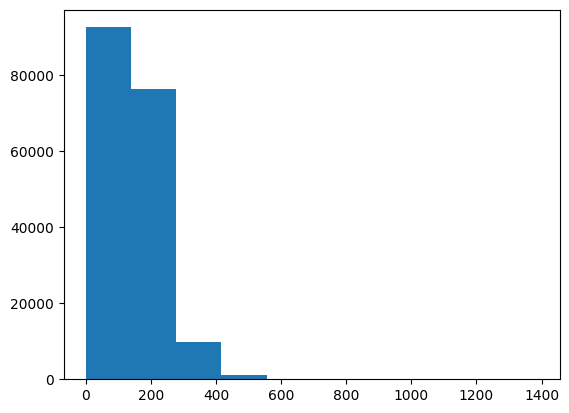

In [54]:
# Check the distribution
plt.hist(char_lens, bins=10)

In [55]:
# How many character length that covers 95% sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [56]:
# Get all alphanumeric characters for max_vocabulary
import string
alphabets = string.ascii_lowercase + string.digits + string.punctuation
alphabets

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [57]:
# Create char-level token vectorizer
NUM_CHAR_TOKENS = len(alphabets) + 2 # Add 2 for space and OOV tokens
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS, output_sequence_length=output_seq_char_len,
                                    pad_to_max_tokens=True, standardize=None)

In [58]:
# Adapt character vectorizer
char_vectorizer.adapt(train_chars)

In [59]:
# Check character-level vectorizer
random_train_chars = random.choice(train_chars)
print(f"Sentence:\n{random_train_chars}")
print(f"Sentence after character vectorization:\n{char_vectorizer([random_train_chars])}")
print(f"Length of vectorized chars: {len(char_vectorizer([random_train_chars])[0])}")

Sentence:
a l t h o u g h   o p i o i d s   a r e   c o m m o n l y   p r e s c r i b e d   t o   a d d r e s s   c h r o n i c   p a i n   ,   t h e y   c o n f e r   r i s k   f o r   m i s u s e   a n d   a d d i c t i o n   i n   s o m e   p a t i e n t s   a n d   m a y   n o t   f u l l y   r e s t o r e   l i f e   f u n c t i o n - p a r t i c u l a r l y   w i t h   r e g a r d   t o   p s y c h o s o c i a l   f a c t o r s   .
Sentence after character vectorization:
[[ 5 12  3 13  7 16 18 13  7 14  4  7  4 10  9  5  8  2 11  7 15 15  7  6
  12 20 14  8  2  9 11  8  4 23  2 10  3  7  5 10 10  8  2  9  9 11 13  8
   7  6  4 11 14  5  4  6 24  3 13  2 20 11  7  6 17  2  8  8  4  9 29 17
   7  8 15  4  9 16  9  2  5  6 10  5 10 10  4 11  3  4  7  6  4  6  9  7
  15  2 14  5  3  4  2  6  3  9  5  6 10 15  5 20  6  7  3 17 16 12 12 20
   8  2  9  3  7  8  2 12  4 17  2 17 16  6 11  3  4  7  6 26 14  5  8  3
   4 11 16 12  5  8 12 20 21  4  3 13  8  2 18  5  8 10  3  7 14  9 20 11


In [60]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 57
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['|', '"', ']', '\\', '[']


### Create character level-embedding layer

In [61]:
 # Create character level embedding layer (25 output dimension based on the paper)
char_embed = layers.Embedding(input_dim=len(char_vocab), output_dim=25, mask_zero=True, name="char_embed")

In [62]:
# Test embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Characters after vectorization and embedding:\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 a l t h o u g h   o p i o i d s   a r e   c o m m o n l y   p r e s c r i b e d   t o   a d d r e s s   c h r o n i c   p a i n   ,   t h e y   c o n f e r   r i s k   f o r   m i s u s e   a n d   a d d i c t i o n   i n   s o m e   p a t i e n t s   a n d   m a y   n o t   f u l l y   r e s t o r e   l i f e   f u n c t i o n - p a r t i c u l a r l y   w i t h   r e g a r d   t o   p s y c h o s o c i a l   f a c t o r s   .

Characters after vectorization and embedding:
 [[[ 0.02826833  0.02768686  0.03902389 ...  0.03549855  0.03565851
    0.04311248]
  [-0.00077224 -0.00380287  0.02657082 ...  0.04332909 -0.01341895
    0.01222875]
  [-0.02217563 -0.02522168  0.02988155 ... -0.0196865   0.01938922
   -0.03471348]
  ...
  [ 0.02685465  0.00699897  0.04150775 ...  0.00430615 -0.04495731
   -0.00280191]
  [ 0.02685465  0.00699897  0.04150775 ...  0.00430615 -0.04495731
   -0.00280191]
  [ 0.02685465  0.00699897  0.04150775 ...  0.00430615 -0.04495731
   -0.00280191]

### Creating 1D Conv Model with Character Embedding

In [63]:
# Make Conv1D model on characters
inputs = layers.Input(shape=(1, ), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=12, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv_char_embeddings")

# Compile the model
model_3.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

# See summary
model_3.summary()

Model: "model_3_conv_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 290)               0         
 Vectorization)                                                  
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1425      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           19264     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_3 (Dense)             (None, 5)

### Create TF dataset for character-level data

In [64]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Fit & Evaluate Model

In [65]:
model_3_history = model_3.fit(train_char_dataset, steps_per_epoch=int(0.1 * len(train_char_dataset)), epochs=5,
                              validation_data = val_char_dataset, validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 8s 11ms/step - loss: 1.1172 - accuracy: 0.5483 - val_loss: 0.8952 - val_accuracy: 0.6519
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 0.8432 - accuracy: 0.6628 - val_loss: 0.7936 - val_accuracy: 0.6922
Epoch 3/5
562/562 [==============================] - 4s 6ms/step - loss: 0.7685 - accuracy: 0.7018 - val_loss: 0.7256 - val_accuracy: 0.7254
Epoch 4/5
562/562 [==============================] - 4s 7ms/step - loss: 0.7185 - accuracy: 0.7265 - val_loss: 0.6966 - val_accuracy: 0.7344
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6999 - accuracy: 0.7342 - val_loss: 0.6757 - val_accuracy: 0.7450


In [66]:
# Make predictions
model_3_preds_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_preds_probs, axis=1)

# Evaluate
model_3_res = evaluate_results(val_labels_encoded, model_3_preds)
model_3_res

945/945 [==============================] - 2s 3ms/step


{'accuracy': 0.7430822189858335,
 'precision': 0.7468668724481962,
 'recall': 0.7430822189858335,
 'f1': 0.7394544466855512}

### Model 4 : Combination of pretrained token embeddings + character embeddings

In [67]:
# Token-level embedding model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output, name="token_model")

In [68]:
# Character-level embedding model
char_inputs = layers.Input(shape=(1, ), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # Bi-LSTM layer
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

In [69]:
# Concatenante both model (hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

In [70]:
# Create output layers with Dropout
combined_dropout = layers.Dropout(0.45)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.45)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

# Construcat model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer, name="model_4_token_char_embeddings")

In [71]:
model_4.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
model_4.summary()

Model: "model_4_token_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 290)                  0         ['char_input[0][0]']          
 Vectorization)                                                                                   
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['

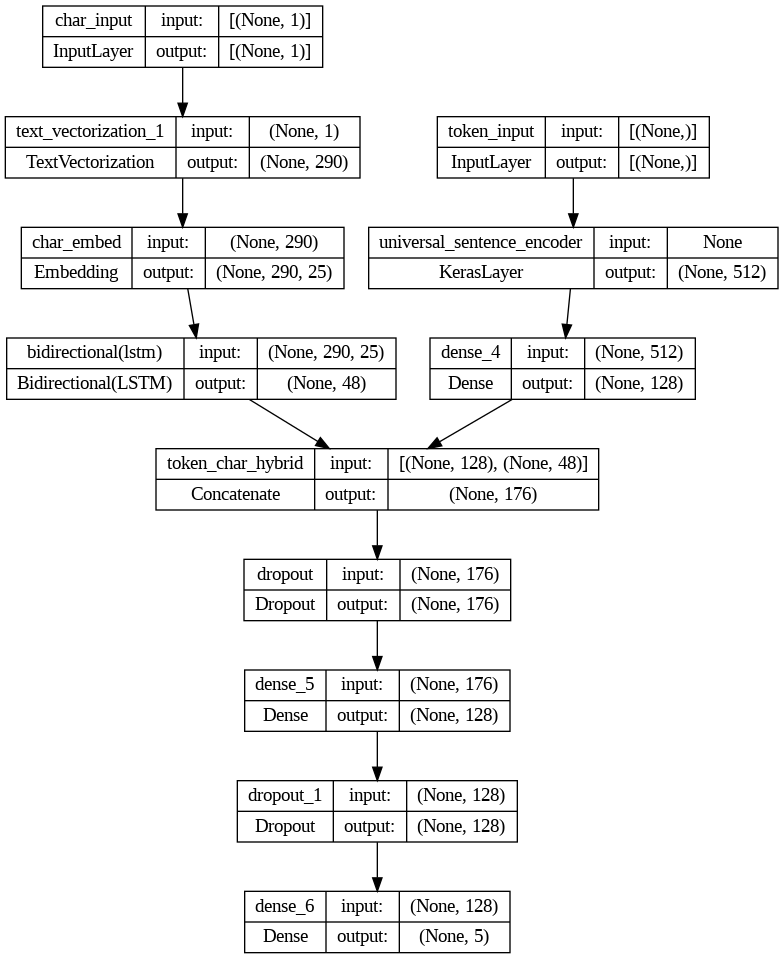

In [72]:
# Visualize the model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [73]:
# Create token and character data into TF Dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_dataset = tf.data.Dataset.zip(train_token_char_data, train_token_char_labels)

val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_dataset = tf.data.Dataset.zip(val_token_char_data, val_token_char_labels)

# Prefetch and batch
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [74]:
# Fit the model
model_4_history = model_4.fit(train_token_char_dataset, steps_per_epoch=int(0.1*len(train_token_char_dataset)),
                              epochs=5, validation_data=val_token_char_dataset, validation_steps=int(0.1 * len(val_token_char_dataset)))

Epoch 1/5
562/562 [==============================] - 38s 47ms/step - loss: 0.9495 - accuracy: 0.6203 - val_loss: 0.7584 - val_accuracy: 0.7081
Epoch 2/5
562/562 [==============================] - 25s 44ms/step - loss: 0.7738 - accuracy: 0.7033 - val_loss: 0.7195 - val_accuracy: 0.7264
Epoch 3/5
562/562 [==============================] - 22s 40ms/step - loss: 0.7461 - accuracy: 0.7145 - val_loss: 0.6709 - val_accuracy: 0.7450
Epoch 4/5
562/562 [==============================] - 23s 41ms/step - loss: 0.7027 - accuracy: 0.7342 - val_loss: 0.6436 - val_accuracy: 0.7513
Epoch 5/5
562/562 [==============================] - 21s 38ms/step - loss: 0.7150 - accuracy: 0.7324 - val_loss: 0.6419 - val_accuracy: 0.7527


In [75]:
# Make prediction using model
model_4_preds_probs = model_4.predict(val_token_char_dataset)
model_4_preds = tf.argmax(model_4_preds_probs, axis = 1)

# Evaluate results
model_4_res = evaluate_results(val_labels_encoded, model_4_preds)
model_4_res

945/945 [==============================] - 22s 19ms/step


{'accuracy': 0.7556269032172647,
 'precision': 0.7561799777665569,
 'recall': 0.7556269032172647,
 'f1': 0.7509328922952373}

### Model 5: Pretrained token embeddings + character embeddings + positional embeddings

In [76]:
# Create positional embeddings

# How many different line of numbers are there
train_df["line_num"].value_counts()

line_num
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

In [77]:
# One-hot encode the line_number using TensorFlow
train_line_numbers_one_hot = tf.one_hot(train_df["line_num"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_num"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_num"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

20.0


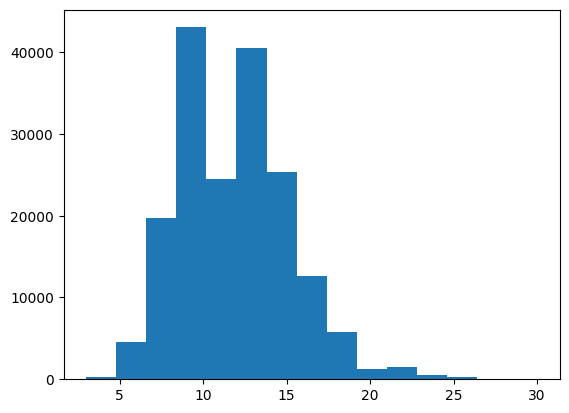

In [78]:
# One-hot encode the total_lines
plt.hist(train_df["total_lines"], bins=15);

# Coverage of total_lines on the 95 percentile
print(np.percentile(train_df["total_lines"], 98));

In [79]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

#### Building the model

In [80]:
# Token-level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(192, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output, name="token_model")

# Character-level model
char_inputs = layers.Input(shape=(1, ), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # Bi-LSTM layer
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Line-number model
line_num_inputs = layers.Input(shape=(15, ), dtype=tf.float32, name="line_num_input")
line_num_dense = layers.Dense(32, activation="relu")(line_num_inputs)
line_num_model = tf.keras.Model(line_num_inputs, line_num_dense, name="line_num_model")

# Total_lines model
total_line_inputs = layers.Input(shape=(20, ), dtype=tf.float32,  name="total_lines_input")
total_line_dense = layers.Dense(32, activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, total_line_dense, name="total_lines_model")

# Concatenate the outputs of token-level and character level model
combined_embedding = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])

dropout_layer = layers.Dense(256, activation="relu")(combined_embedding)
dropout_layer = layers.Dropout(0.45)(dropout_layer)

# Concatenate the line number, total_lines, and the combined model of token and character level model
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_num_model.output,
                                                                                 total_line_model.output, dropout_layer])

# Output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# Model
model_5 = tf.keras.Model(inputs=[line_num_model.input, total_line_model.input, token_model.input, char_model.input],
                         outputs=output_layer, name="model_5_tribrid")

In [81]:
model_5.summary()

Model: "model_5_tribrid"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 290)                  0         ['char_input[0][0]']          
 Vectorization)                                                                                   
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0]

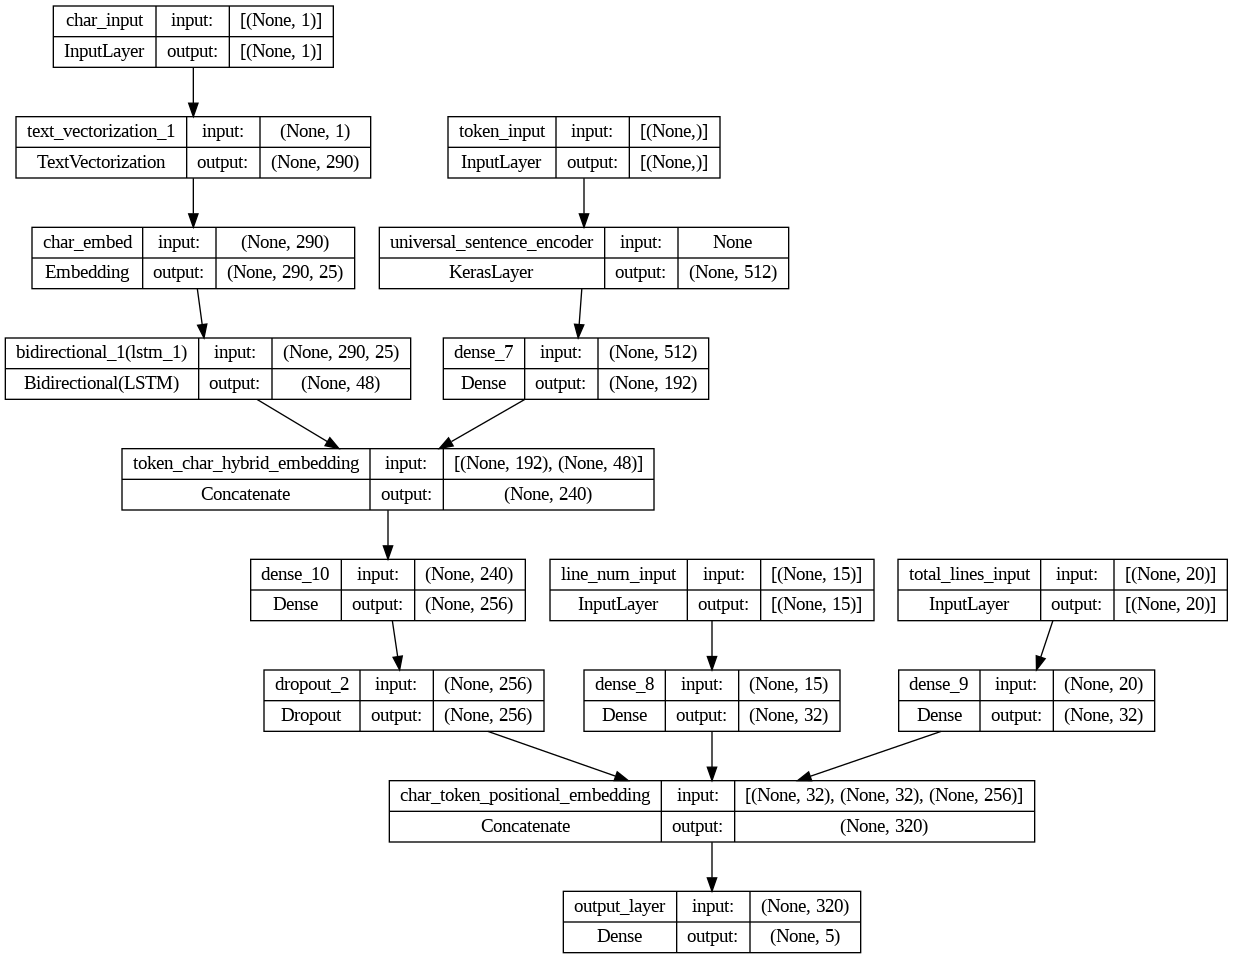

In [82]:
# Visualize the model
plot_model(model_5, show_shapes=True)

In [83]:
# Label smoothing to prevent overfitting
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

#### Create dataset for tribrid embedding

In [84]:
# Dataset with all four input data
# Training data
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation data
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [85]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

#### Fit and evaluate the model

In [86]:
model_5_history = model_5.fit(train_char_token_pos_dataset, steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=5, validation_data=val_char_token_pos_dataset, validation_steps=int(0.1 * len(val_char_token_pos_dataset)))


Epoch 1/5
562/562 [==============================] - 38s 50ms/step - loss: 1.0791 - accuracy: 0.7356 - val_loss: 0.9703 - val_accuracy: 0.8068
Epoch 2/5
562/562 [==============================] - 28s 50ms/step - loss: 0.9536 - accuracy: 0.8262 - val_loss: 0.9412 - val_accuracy: 0.8324
Epoch 3/5
562/562 [==============================] - 23s 41ms/step - loss: 0.9365 - accuracy: 0.8342 - val_loss: 0.9257 - val_accuracy: 0.8484
Epoch 4/5
562/562 [==============================] - 24s 43ms/step - loss: 0.9274 - accuracy: 0.8453 - val_loss: 0.9235 - val_accuracy: 0.8398
Epoch 5/5
562/562 [==============================] - 22s 39ms/step - loss: 0.9245 - accuracy: 0.8454 - val_loss: 0.9142 - val_accuracy: 0.8491


In [87]:
# Predict and evaluate model
model_5_preds_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_preds_probs, axis=1)

model_5_res = evaluate_results(val_labels_encoded, model_5_preds)
model_5_res

945/945 [==============================] - 20s 19ms/step


{'accuracy': 0.8500926784059314,
 'precision': 0.8538046951367546,
 'recall': 0.8500926784059314,
 'f1': 0.8463909693643541}

## Compare Model Results

In [88]:
all_model_results = pd.DataFrame({"model_0_baseline": model_0_res,
                                  "model_1_custom_token_embedding": model_1_res,
                                  "model_2_pretrained_token_embedding": model_2_res,
                                  "model_3_custom_char_embedding": model_3_res,
                                  "model_4_hybrid_char_token_embedding": model_4_res,
                                  "model_5_pos_char_token_embedding": model_5_res})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.817854,0.820149,0.817854,0.815205
model_2_pretrained_token_embedding,0.735635,0.731655,0.735635,0.729868
model_3_custom_char_embedding,0.743082,0.746867,0.743082,0.739454
model_4_hybrid_char_token_embedding,0.755627,0.756180,0.755627,0.750933
model_5_pos_char_token_embedding,0.850093,0.853805,0.850093,0.846391


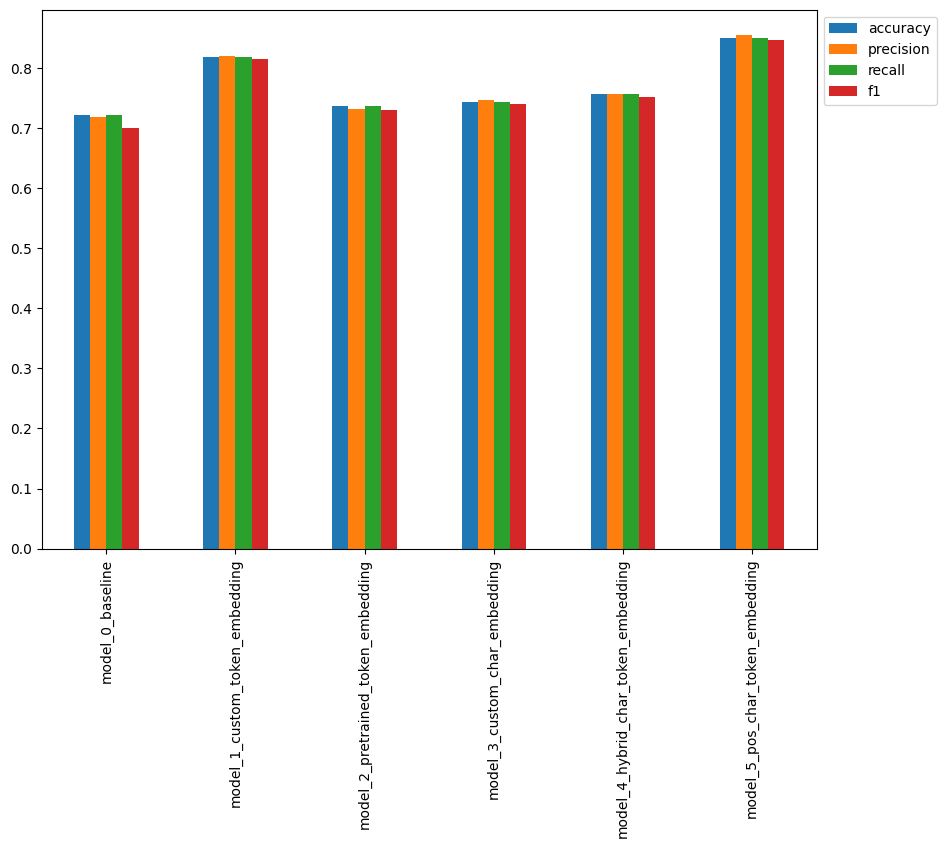

In [89]:
# Plot all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

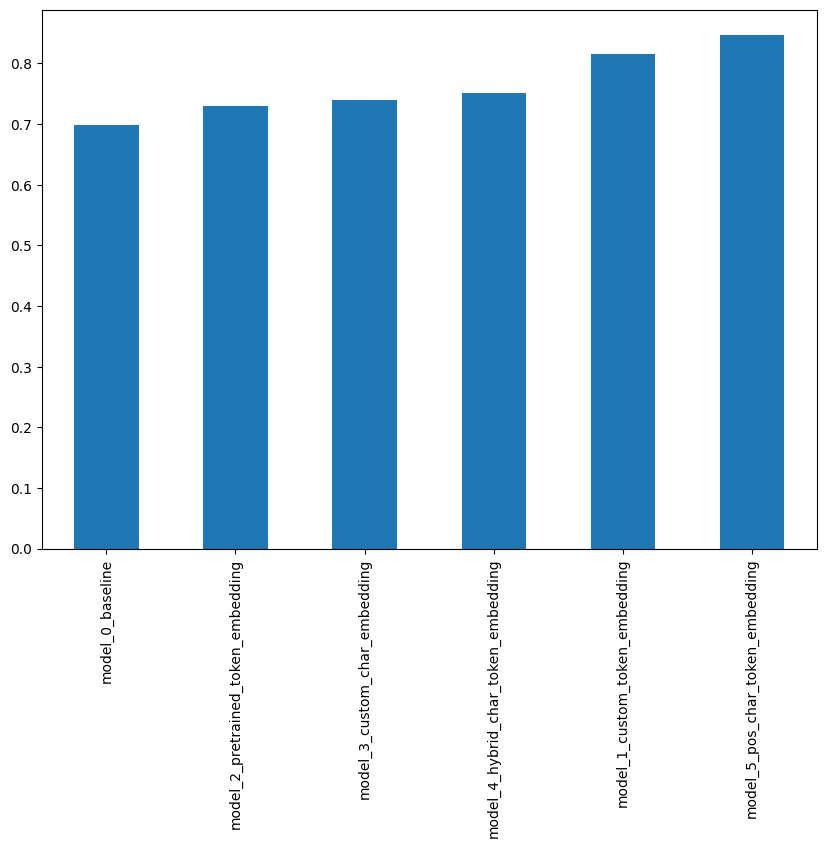

In [90]:
# Sort score by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

## Save and Load Model

In [91]:
# Save the best performing model
model_5.save("skimlit_tribrid_model_best")

In [92]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model_best")

In [93]:
# Test the model on validation data
loaded_model_preds_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_model_preds = tf.argmax(loaded_model_preds_probs, axis=1)
loaded_model_preds[:5]

945/945 [==============================] - 38s 34ms/step


<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 2])>

In [95]:
# Calculate results
loaded_model_val_res = evaluate_results(val_labels_encoded, loaded_model_preds)
loaded_model_val_res

{'accuracy': 0.8500926784059314,
 'precision': 0.8538046951367546,
 'recall': 0.8500926784059314,
 'f1': 0.8463909693643541}

In [96]:
# Test model on test data
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_total_lines_one_hot, test_sentences, test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [97]:
loaded_model_preds_probs = loaded_model.predict(test_char_token_pos_dataset)
loaded_model_preds = tf.argmax(loaded_model_preds_probs, axis=1)

# Calculate results
loaded_model_test_res = evaluate_results(test_labels_encoded, loaded_model_preds)
loaded_model_test_res

942/942 [==============================] - 24s 26ms/step


{'accuracy': 0.8448979591836735,
 'precision': 0.8483592248626105,
 'recall': 0.8448979591836735,
 'f1': 0.8410598622108035}